In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import tensor as t
from torch.utils.data import TensorDataset, DataLoader
from dnn_app_utils_v3 import load_data

In [45]:
f=  lambda x,y:-8*x-16*y+x**2+4*y**2
f_x = lambda x: -8 +2*x
f_y = lambda y: -16 + 8*y

In [46]:
x = np.linspace(-6,6,50)
y = np.linspace(-6,6,50)
X,Y = np.meshgrid(x,y)
Z = f(X,Y)

Text(0.5, 0.5, '$Y$')

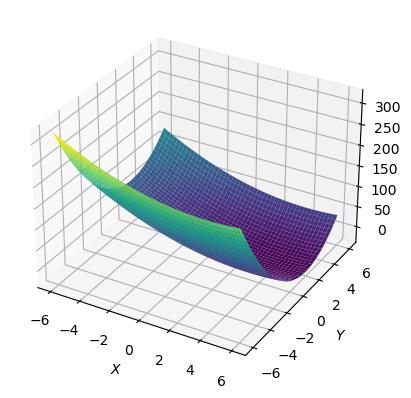

In [47]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

In [48]:
def SGD():
    alpha = 0.01
    x = np.array([[-6,6]])
    x1 = x[0,0] - alpha*f_x(x[0,0])
    y1 = x[0,1] - alpha*f_y(x[0,1])
    x = np.append(x,[[x1,y1]],axis=0)
    while np.sqrt(np.sum(np.square(x[-2,0]-x[-1,0]))) > 0.0005:
        xi = x[-1,0] - alpha*f_x(x[-1,0])
        yi = x[-1,1] - alpha*f_y(x[-1,1])
        x = np.append(x,[[xi,yi]],axis=0)
    return x


# Momentum
$
W_{t+1} = W_t -\alpha M_t \\
M_t = \beta_1 M_{t-1} + (1 - \beta_1)\frac{\delta L}{\delta W_t} \\
\beta_1 = 0.9 \space \space \space M_0 =0
$

# Root Mean Square Propagation (RMSP)
$
W_{t+1} = W_t -\frac{\alpha}{\sqrt{V_t + \varepsilon}}\frac{\delta L}{\delta W_t}\\
V_t = \beta_2 V_{t-1} + (1- \beta_2){\frac{\delta L}{\delta W_t}}^2 \\
V_0 =0 \space, \varepsilon = 10^{-8} \space , \beta_2 = 0.9
$

# Mathematical Aspect of Adam Optimizer
$
W_{t+1} = W_t - \hat{M_t}\frac{\alpha}{\sqrt{\hat{V_t} + \varepsilon}} \\
\hat{M_t} =  ̂\frac{M_t}{1-\beta_1} \space \space \space , \hat{V_t}=\frac{V_t}{1-\beta_2} \\
\beta_1 = 0.9 \space \space , \space \beta_2= 0.999
$

In [49]:
def Adam():
    x = np.array([[-6,6]])
    V = np.array([[0,0]])
    M = np.array([[0,0]])
    epsilon = 1e-8
    beta_1 = 0.9
    beta_2 = 0.999
    alpha = 0.01
    m_hat = (M[-1]*beta_1 + (1-beta_1)*np.array([f_x(x[-1,0]),f_y(x[-1,1])]))/(1-beta_1)
    v_hat = (V[-1]*beta_2 + (1-beta_2)*np.square(np.array([f_x(x[-1,0]),f_y(x[-1,1])])))/(1-beta_2)
    x_1 = x[-1]  - m_hat*alpha/(np.sqrt(v_hat+epsilon))
    x = np.append(x,[x_1],axis=0)
    while np.sqrt(np.sum(np.square(x[-2,0]-x[-1,0]))) > 0.0005 :
        m_hat = (M[-1]*beta_1 + (1-beta_1)*np.array([f_x(x[-1,0]),f_y(x[-1,1])]))/(1-beta_1)
        v_hat = (V[-1]*beta_2 + (1-beta_2)*np.square(np.array([f_x(x[-1,0]),f_y(x[-1,1])])))/(1-beta_2)
        x_new = x[-1]  - m_hat*alpha/(np.sqrt(v_hat+epsilon))
        x = np.append(x,[x_new],axis=0)
    return x



In [50]:
sol = SGD()

In [51]:
sol2 = Adam()

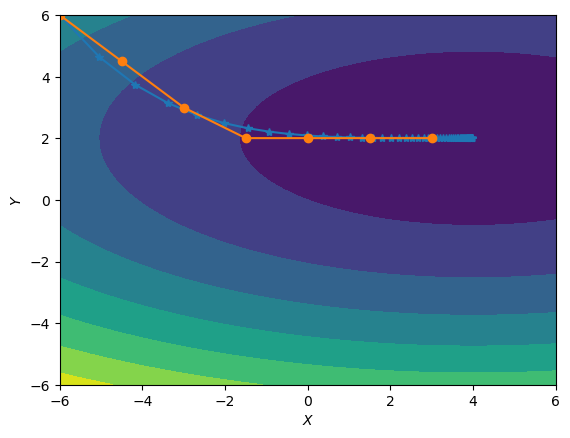

In [52]:
fig, ax = plt.subplots(1, 1)
ax.contourf(X, Y, Z)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.plot(sol[::5,0],sol[::5,1],'-*')
ax.plot(sol2[::150,0],sol2[::150,1],'-o')

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(train_x_orig.shape, train_y.shape, test_x_orig.shape, test_y.shape)

train_x = torch.from_numpy(train_x_orig.reshape(-1, 64 * 64 * 3)).type(torch.float32) / 255.
test_x = torch.from_numpy(test_x_orig.reshape(-1, 64 * 64 * 3)).type(torch.float32) / 255.
train_y = torch.from_numpy(train_y.reshape(-1, 1)).type(torch.float32)
test_y = torch.from_numpy(test_y.reshape(-1, 1)).type(torch.float32)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)
torch.Size([209, 12288]) torch.Size([209, 1]) torch.Size([50, 12288]) torch.Size([50, 1])


In [3]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=209, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [4]:

n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
model = nn.Sequential(nn.Linear(n_x, n_h), nn.ReLU(), nn.Linear(n_h, n_y),nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=12288, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=1, bias=True)
  (3): Sigmoid()
)

In [8]:
criterion = nn.BCELoss()
learning_rate = 0.0075
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.0001)

#scheduler
lambda1 = lambda epoch: (epoch+1)/10
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lambda1)

In [11]:
cost_SGD = np.array([])
cost_Adam = np.array([])
n_epoch = 10
print(optimizer.state_dict())
for epoch in range(n_epoch):
    for x, y in train_loader:
        out = model(x)
        loss = criterion(out,y)
        cost_SGD = np.append(cost_SGD,loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"epoch {epoch+1}  lr={optimizer.state_dict()['param_groups'][0]['lr']}")
for epoch in range(n_epoch):
    for x, y in train_loader:
        out = model(x)
        loss = criterion(out,y)
        cost_Adam = np.append(cost_Adam,loss.item())
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}, 3: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.00825, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'initial_lr': 0.0075, 'params': [0, 1, 2, 3]}]}
epoch 1  lr=0.009
epoch 2  lr=0.00975
epoch 3  lr=0.010499999999999999
epoch 4  lr=0.01125
epoch 5  lr=0.012
epoch 6  lr=0.01275
epoch 7  lr=0.0135
epoch 8  lr=0.014249999999999999
epoch 9  lr=0.015
epoch 10  lr=0.01575


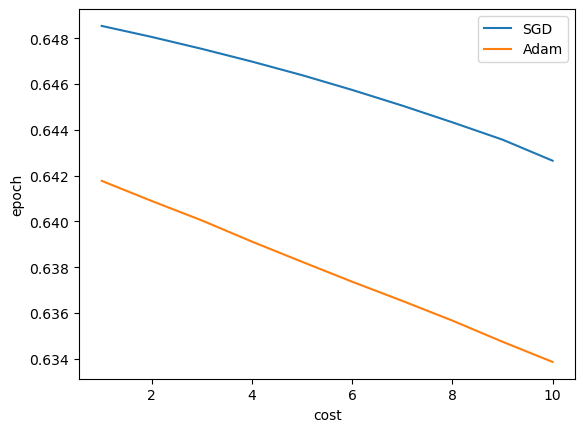

In [12]:
n1 = np.arange(1,len(cost_SGD)+1)
n2 = np.arange(1,len(cost_Adam)+1)
plt.plot(n1,cost_SGD)
plt.plot(n2,cost_Adam)
plt.xlabel("cost")
plt.ylabel("epoch")
plt.legend(["SGD","Adam"])